In [ ]:
import pandas as pd

# Carica i risultati dal file CSV
df = pd.read_csv('../results/2class/predictions/all_predictions.csv')


# Analisi Sentiment Analysis Amazon Reviews - 2 Classi

Questo notebook analizza i risultati del modello di sentiment analysis a 2 classi (positivo/negativo) su recensioni Amazon.

## Dataset e Modelli Analizzati

Il dataset contiene predizioni di 3 diversi modelli:
- **VADER**: Rule-based sentiment analyzer
- **TF-IDF + Logistic Regression**: Approccio tradizionale ML
- **Gemini**: Large Language Model di Google

## Indice
1. [Caricamento e Esplorazione dei Dati](#caricamento)
2. [Statistiche Descrittive](#statistiche)
3. [Analisi delle Performance](#performance)
4. [Confronto tra Modelli](#confronto)
5. [Analisi degli Errori](#errori)
6. [Conclusioni](#conclusioni)

## 1. Caricamento e Esplorazione dei Dati {#caricamento}

In [2]:
# Importiamo le librerie necessarie per l'analisi
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

# Configurazione per i grafici
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

print("Librerie caricate con successo!")

Librerie caricate con successo!


In [3]:
# Esploriamo il dataset
print("📊 INFORMAZIONI GENERALI SUL DATASET")
print("="*50)
print(f"Numero di campioni: {len(df):,}")
print(f"Numero di colonne: {df.shape[1]}")
print(f"\nColonne disponibili:")
for col in df.columns:
    print(f"  - {col}")

print(f"\nPrime 3 righe del dataset:")
df.head(3)

📊 INFORMAZIONI GENERALI SUL DATASET
Numero di campioni: 20,000
Numero di colonne: 5

Colonne disponibili:
  - text
  - true_label
  - vader_pred
  - tfidf_pred
  - gemini_pred

Prime 3 righe del dataset:


,text,true_label,vader_pred,tfidf_pred,gemini_pred
0,Great Supplement to a Great Game\n\nUntil rece...,pos,1,1,pos
1,The CD that starts it all\n\nI have beeen a bi...,pos,1,1,pos
2,The Richest Man In Babylon\n\nSound financial ...,pos,1,1,pos


## 2. Statistiche Descrittive {#statistiche}

In [4]:
# Normalizziamo i dati per un'analisi consistente
print("🔄 NORMALIZZAZIONE DEI DATI")
print("="*40)

# Convertiamo tutto a formato stringa per semplicità
df_clean = df.copy()

# Mappiamo i valori numerici VADER/TF-IDF a stringhe
df_clean['vader_pred_str'] = df_clean['vader_pred'].map({0: 'neg', 1: 'pos'})
df_clean['tfidf_pred_str'] = df_clean['tfidf_pred'].map({0: 'neg', 1: 'pos'})

print("Mapping completato:")
print("- VADER: 0 → 'neg', 1 → 'pos'")
print("- TF-IDF: 0 → 'neg', 1 → 'pos'")
print("- Gemini: già in formato stringa")
print("- True Labels: già in formato stringa")

# Verifichiamo la distribuzione delle label vere
print("\n📈 DISTRIBUZIONE DELLE LABEL VERE:")
label_counts = df_clean['true_label'].value_counts()
print(label_counts)
print(f"\nPercentuale:")
for label, count in label_counts.items():
    pct = (count / len(df_clean)) * 100
    print(f"  {label}: {pct:.1f}%")

🔄 NORMALIZZAZIONE DEI DATI
Mapping completato:
- VADER: 0 → 'neg', 1 → 'pos'
- TF-IDF: 0 → 'neg', 1 → 'pos'
- Gemini: già in formato stringa
- True Labels: già in formato stringa

📈 DISTRIBUZIONE DELLE LABEL VERE:
true_label
neg    10065
pos     9935
Name: count, dtype: int64

Percentuale:
  neg: 50.3%
  pos: 49.7%


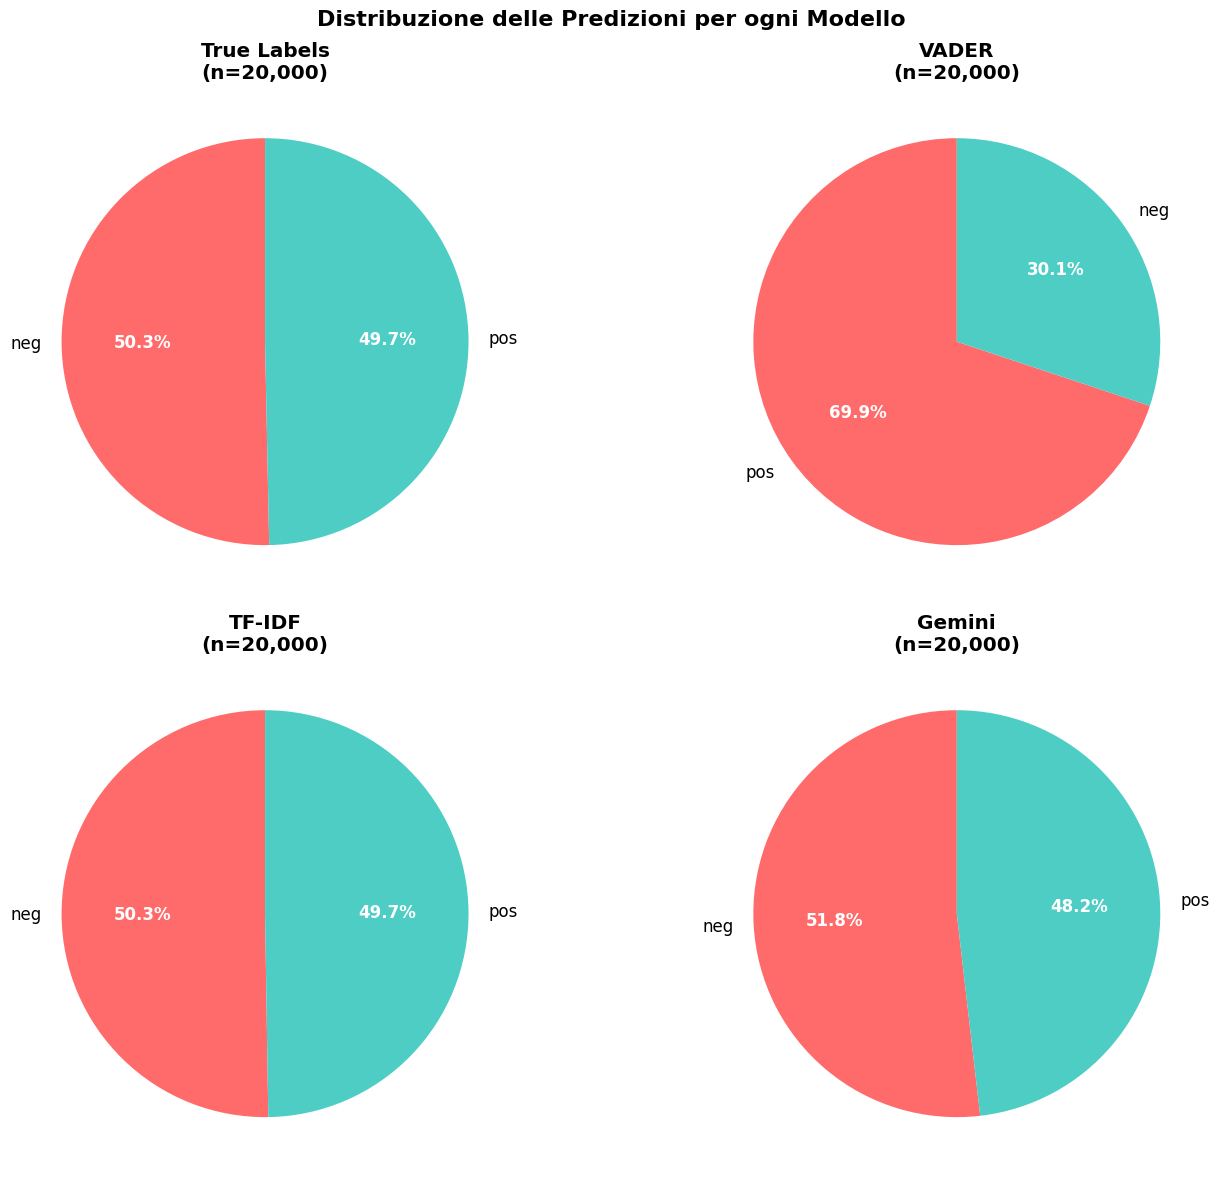


📊 RIEPILOGO DELLE DISTRIBUZIONI:

True Labels:
  neg: 10,065 (50.3%)
  pos: 9,935 (49.7%)

VADER:
  pos: 13,979 (69.9%)
  neg: 6,021 (30.1%)

TF-IDF:
  neg: 10,051 (50.3%)
  pos: 9,949 (49.7%)

Gemini:
  neg: 10,367 (51.8%)
  pos: 9,633 (48.2%)


In [5]:
# Visualizziamo la distribuzione delle predizioni per ogni modello
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Distribuzione delle Predizioni per ogni Modello', fontsize=16, fontweight='bold')

models = [
    ('true_label', 'True Labels', axes[0, 0]),
    ('vader_pred_str', 'VADER', axes[0, 1]),
    ('tfidf_pred_str', 'TF-IDF', axes[1, 0]),
    ('gemini_pred', 'Gemini', axes[1, 1])
]

colors = ['#FF6B6B', '#4ECDC4']

for col, title, ax in models:
    counts = df_clean[col].value_counts()
    wedges, texts, autotexts = ax.pie(counts.values, labels=counts.index, autopct='%1.1f%%', 
                                     colors=colors, startangle=90)
    ax.set_title(f'{title}\n(n={len(df_clean):,})', fontweight='bold')
    
    # Miglioriamo la leggibilità del testo
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')

plt.tight_layout()
plt.show()

# Statistiche testuali
print("\n📊 RIEPILOGO DELLE DISTRIBUZIONI:")
print("="*50)
for col, title, _ in models:
    counts = df_clean[col].value_counts()
    print(f"\n{title}:")
    for label, count in counts.items():
        pct = (count / len(df_clean)) * 100
        print(f"  {label}: {count:,} ({pct:.1f}%)")

### Osservazioni iniziali:
- **Dataset bilanciato**: Le true labels sono quasi perfettamente bilanciate (50.3% neg, 49.7% pos)
- **VADER** ha un forte bias verso le predizioni positive (69.9% pos vs 30.1% neg)
- **TF-IDF** mantiene quasi perfettamente la distribuzione delle true labels
- **Gemini** è molto vicino alla distribuzione delle true labels (51.8% neg vs 48.2% pos)

## 3. Analisi delle Performance {#performance}

In [6]:
# Calcoliamo le metriche di performance per ogni modello
def calculate_metrics(y_true, y_pred, model_name):
    """Calcola le metriche di performance per un modello"""
    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    
    return {
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    }

# Calcoliamo le metriche per tutti i modelli
y_true = df_clean['true_label']

models_metrics = [
    calculate_metrics(y_true, df_clean['vader_pred_str'], 'VADER'),
    calculate_metrics(y_true, df_clean['tfidf_pred_str'], 'TF-IDF'),
    calculate_metrics(y_true, df_clean['gemini_pred'], 'Gemini')
]

# Creiamo un DataFrame con i risultati
metrics_df = pd.DataFrame(models_metrics)
metrics_df = metrics_df.round(4)

print("🎯 METRICHE DI PERFORMANCE")
print("="*60)
print(metrics_df.to_string(index=False))

# Identifichiamo il modello migliore per ogni metrica
print("\n🏆 MODELLI MIGLIORI PER METRICA:")
print("="*40)
for metric in ['Accuracy', 'Precision', 'Recall', 'F1-Score']:
    best_idx = metrics_df[metric].idxmax()
    best_model = metrics_df.iloc[best_idx]['Model']
    best_value = metrics_df.iloc[best_idx][metric]
    print(f"{metric}: {best_model} ({best_value:.4f})")

🎯 METRICHE DI PERFORMANCE
 Model  Accuracy  Precision  Recall  F1-Score
 VADER    0.7198     0.7634  0.7198    0.7083
TF-IDF    0.9315     0.9315  0.9315    0.9315
Gemini    0.9621     0.9625  0.9621    0.9621

🏆 MODELLI MIGLIORI PER METRICA:
Accuracy: Gemini (0.9621)
Precision: Gemini (0.9625)
Recall: Gemini (0.9621)
F1-Score: Gemini (0.9621)


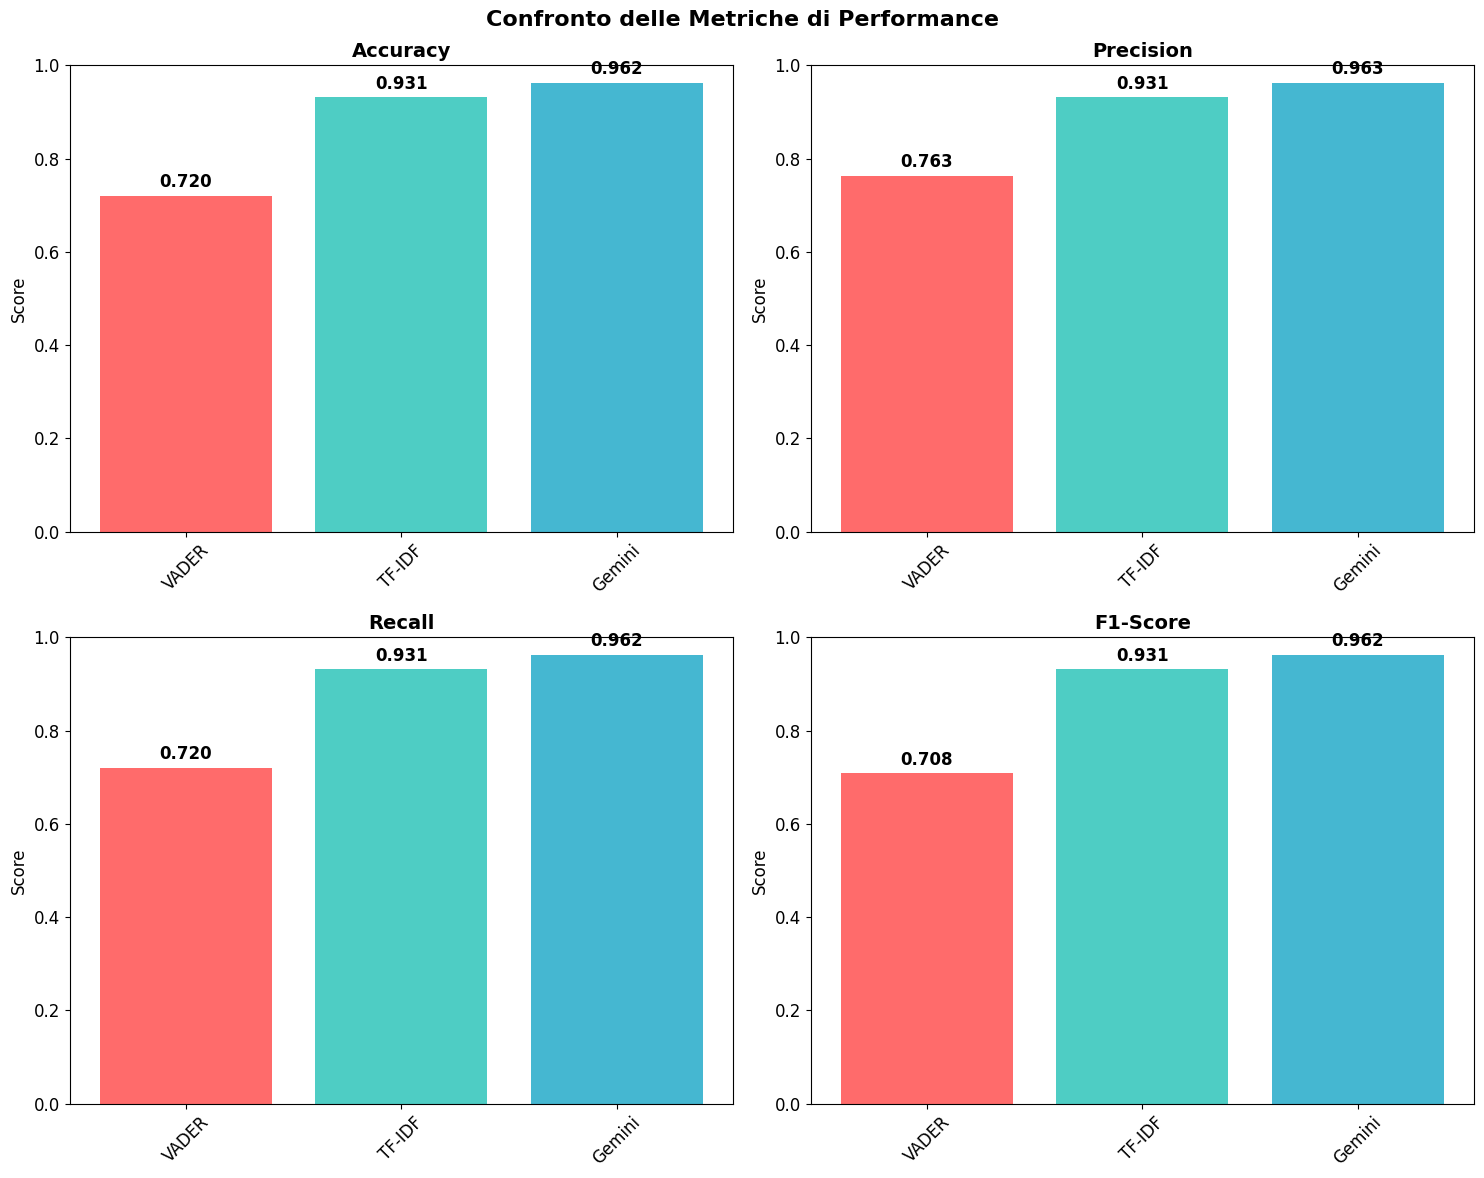

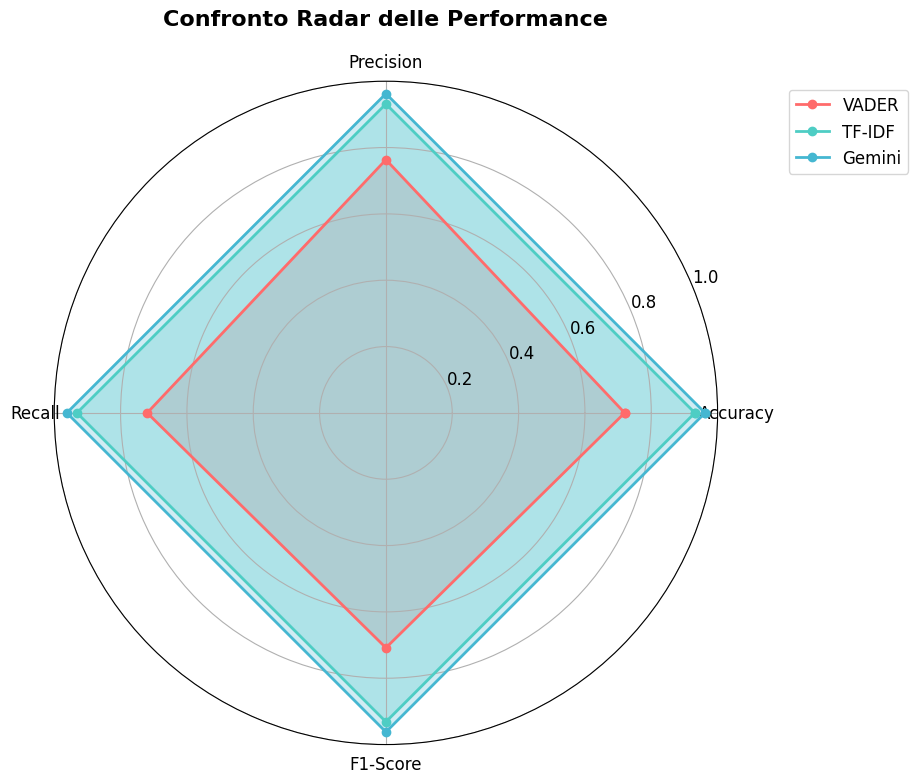

In [7]:
# Visualizziamo le metriche in un grafico a barre
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Confronto delle Metriche di Performance', fontsize=16, fontweight='bold')

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

for i, metric in enumerate(metrics):
    ax = axes[i//2, i%2]
    bars = ax.bar(metrics_df['Model'], metrics_df[metric], color=colors)
    ax.set_title(f'{metric}', fontweight='bold', fontsize=14)
    ax.set_ylim(0, 1)
    ax.set_ylabel('Score')
    
    # Aggiungiamo i valori sopra le barre
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
               f'{height:.3f}', ha='center', va='bottom', fontweight='bold')
    
    # Ruotiamo le etichette dell'asse x
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Grafico radar per confronto complessivo
from math import pi

fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(projection='polar'))

categories = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
N = len(categories)

# Calcola gli angoli per ogni asse
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

# Plot per ogni modello
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
models = ['VADER', 'TF-IDF', 'Gemini']

for i, model in enumerate(models):
    values = metrics_df[metrics_df['Model'] == model][categories].iloc[0].tolist()
    values += values[:1]
    
    ax.plot(angles, values, 'o-', linewidth=2, label=model, color=colors[i])
    ax.fill(angles, values, alpha=0.25, color=colors[i])

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories)
ax.set_ylim(0, 1)
ax.set_title('Confronto Radar delle Performance', size=16, fontweight='bold', pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
ax.grid(True)

plt.tight_layout()
plt.show()

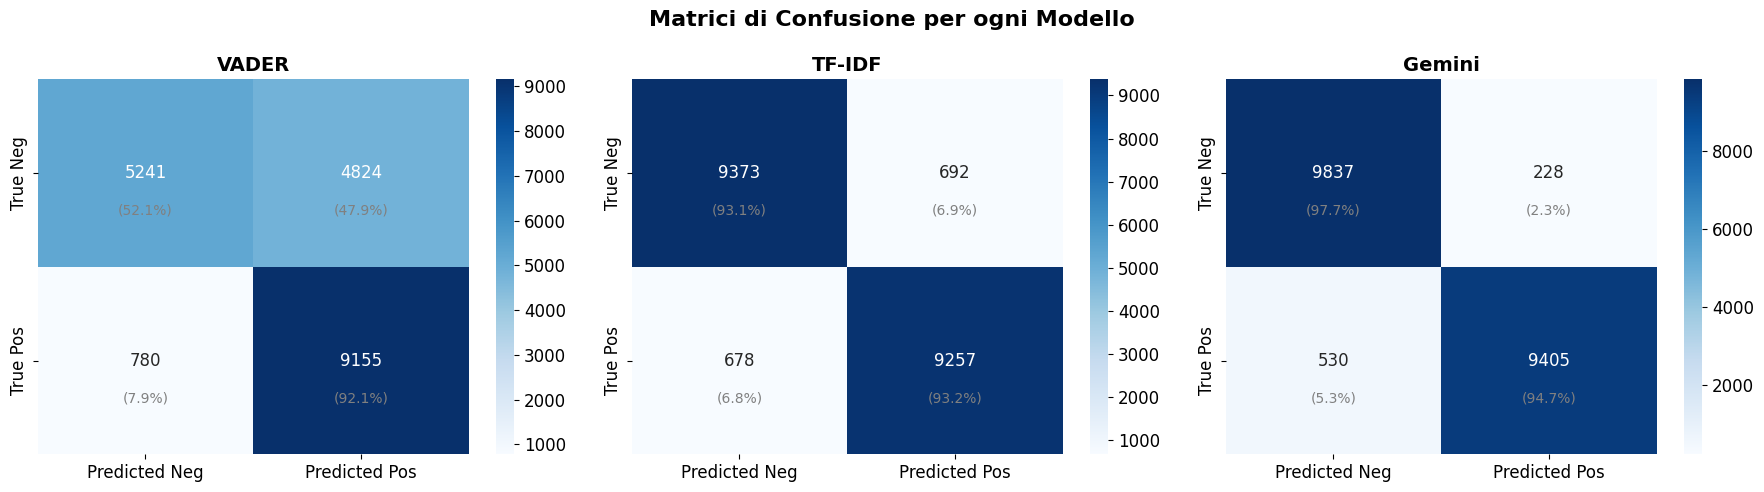


📋 REPORT DI CLASSIFICAZIONE DETTAGLIATI

🔍 VADER:
------------------------------
              precision    recall  f1-score   support

         neg       0.87      0.52      0.65     10065
         pos       0.65      0.92      0.77      9935

    accuracy                           0.72     20000
   macro avg       0.76      0.72      0.71     20000
weighted avg       0.76      0.72      0.71     20000


🔍 TF-IDF:
------------------------------
              precision    recall  f1-score   support

         neg       0.93      0.93      0.93     10065
         pos       0.93      0.93      0.93      9935

    accuracy                           0.93     20000
   macro avg       0.93      0.93      0.93     20000
weighted avg       0.93      0.93      0.93     20000


🔍 Gemini:
------------------------------
              precision    recall  f1-score   support

         neg       0.95      0.98      0.96     10065
         pos       0.98      0.95      0.96      9935

    accuracy    

In [8]:
# Matrice di confusione per ogni modello
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Matrici di Confusione per ogni Modello', fontsize=16, fontweight='bold')

models_data = [
    ('VADER', df_clean['vader_pred_str']),
    ('TF-IDF', df_clean['tfidf_pred_str']),
    ('Gemini', df_clean['gemini_pred'])
]

for i, (model_name, y_pred) in enumerate(models_data):
    cm = confusion_matrix(y_true, y_pred, labels=['neg', 'pos'])
    
    # Calcoliamo le percentuali
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    
    # Creiamo la heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i],
                xticklabels=['Predicted Neg', 'Predicted Pos'],
                yticklabels=['True Neg', 'True Pos'])
    
    axes[i].set_title(f'{model_name}', fontweight='bold', fontsize=14)
    
    # Aggiungiamo le percentuali come testo aggiuntivo
    for j in range(2):
        for k in range(2):
            axes[i].text(k+0.5, j+0.7, f'({cm_percent[j,k]:.1f}%)', 
                        ha='center', va='center', fontsize=10, color='gray')

plt.tight_layout()
plt.show()

# Stampiamo i report di classificazione dettagliati
print("\n📋 REPORT DI CLASSIFICAZIONE DETTAGLIATI")
print("="*80)

for model_name, y_pred in models_data:
    print(f"\n🔍 {model_name}:")
    print("-" * 30)
    print(classification_report(y_true, y_pred))

## 4. Confronto tra Modelli {#confronto}

In [9]:
# Analizziamo i casi di accordo e disaccordo tra i modelli
print("🤝 ANALISI DEGLI ACCORDI TRA MODELLI")
print("="*50)

# Creiamo una matrice di accordo
agreement_data = []

# Confronti a coppie
pairs = [
    ('VADER', 'vader_pred_str', 'TF-IDF', 'tfidf_pred_str'),
    ('VADER', 'vader_pred_str', 'Gemini', 'gemini_pred'),
    ('TF-IDF', 'tfidf_pred_str', 'Gemini', 'gemini_pred')
]

for model1_name, model1_col, model2_name, model2_col in pairs:
    agreement = (df_clean[model1_col] == df_clean[model2_col]).sum()
    agreement_pct = (agreement / len(df_clean)) * 100
    
    print(f"\n{model1_name} vs {model2_name}:")
    print(f"  Accordo: {agreement:,} campioni ({agreement_pct:.1f}%)")
    print(f"  Disaccordo: {len(df_clean) - agreement:,} campioni ({100 - agreement_pct:.1f}%)")

# Accordo tra tutti e tre i modelli
all_agree = ((df_clean['vader_pred_str'] == df_clean['tfidf_pred_str']) & 
            (df_clean['tfidf_pred_str'] == df_clean['gemini_pred'])).sum()
all_agree_pct = (all_agree / len(df_clean)) * 100

print(f"\n🎯 ACCORDO TRA TUTTI E TRE I MODELLI:")
print(f"  Accordo completo: {all_agree:,} campioni ({all_agree_pct:.1f}%)")
print(f"  Disaccordo: {len(df_clean) - all_agree:,} campioni ({100 - all_agree_pct:.1f}%)")

# Analizziamo quando tutti i modelli sono corretti vs quando sbagliano
all_correct = ((df_clean['vader_pred_str'] == df_clean['true_label']) & 
               (df_clean['tfidf_pred_str'] == df_clean['true_label']) & 
               (df_clean['gemini_pred'] == df_clean['true_label'])).sum()
all_correct_pct = (all_correct / len(df_clean)) * 100

all_wrong = ((df_clean['vader_pred_str'] != df_clean['true_label']) & 
             (df_clean['tfidf_pred_str'] != df_clean['true_label']) & 
             (df_clean['gemini_pred'] != df_clean['true_label'])).sum()
all_wrong_pct = (all_wrong / len(df_clean)) * 100

print(f"\n✅ PREDIZIONI CORRETTE DA TUTTI:")
print(f"  Tutti corretti: {all_correct:,} campioni ({all_correct_pct:.1f}%)")
print(f"  Tutti sbagliati: {all_wrong:,} campioni ({all_wrong_pct:.1f}%)")

🤝 ANALISI DEGLI ACCORDI TRA MODELLI

VADER vs TF-IDF:
  Accordo: 14,526 campioni (72.6%)
  Disaccordo: 5,474 campioni (27.4%)

VADER vs Gemini:
  Accordo: 14,286 campioni (71.4%)
  Disaccordo: 5,714 campioni (28.6%)

TF-IDF vs Gemini:
  Accordo: 18,606 campioni (93.0%)
  Disaccordo: 1,394 campioni (7.0%)

🎯 ACCORDO TRA TUTTI E TRE I MODELLI:
  Accordo completo: 13,709 campioni (68.5%)
  Disaccordo: 6,291 campioni (31.5%)

✅ PREDIZIONI CORRETTE DA TUTTI:
  Tutti corretti: 13,507 campioni (67.5%)
  Tutti sbagliati: 202 campioni (1.0%)


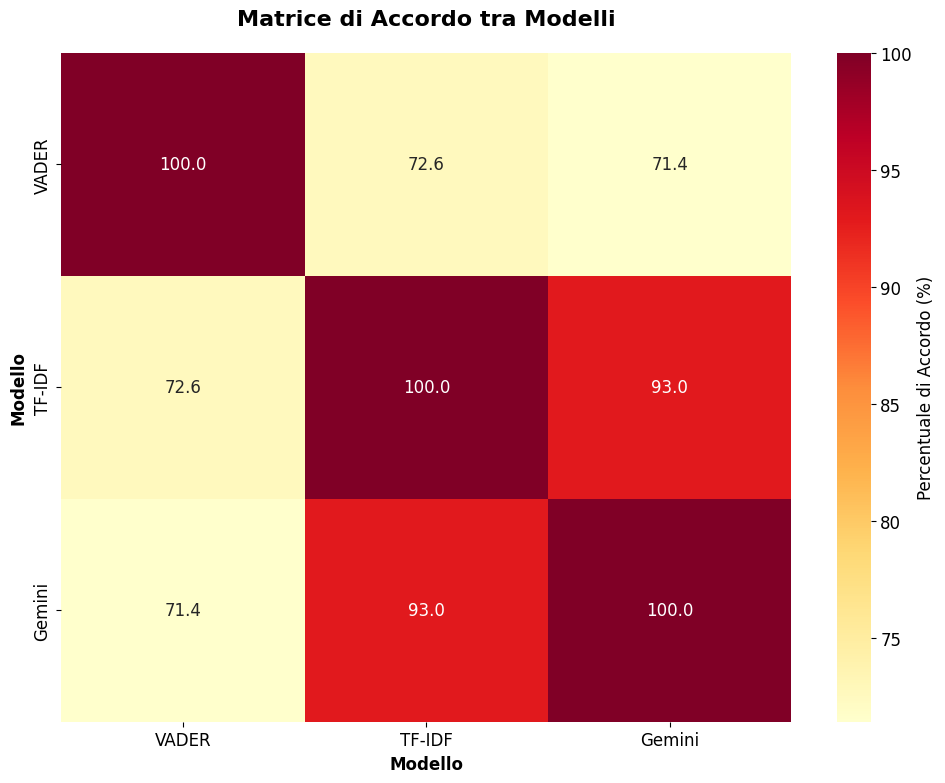


🔍 PATTERN DI PREDIZIONE
Top 10 pattern di predizione più comuni:
 1. VADER: pos, TF-IDF: pos, Gemini: pos → 8,561 (42.8%)
 2. VADER: neg, TF-IDF: neg, Gemini: neg → 5,148 (25.7%)
 3. VADER: pos, TF-IDF: neg, Gemini: neg → 4,364 (21.8%)
 4. VADER: pos, TF-IDF: pos, Gemini: neg → 666 (3.3%)
 5. VADER: neg, TF-IDF: pos, Gemini: pos → 533 (2.7%)
 6. VADER: pos, TF-IDF: neg, Gemini: pos → 388 (1.9%)
 7. VADER: neg, TF-IDF: pos, Gemini: neg → 189 (0.9%)
 8. VADER: neg, TF-IDF: neg, Gemini: pos → 151 (0.8%)


In [10]:
# Creiamo un heatmap degli accordi tra modelli
agreement_matrix = np.zeros((3, 3))
model_names = ['VADER', 'TF-IDF', 'Gemini']
model_cols = ['vader_pred_str', 'tfidf_pred_str', 'gemini_pred']

for i, col1 in enumerate(model_cols):
    for j, col2 in enumerate(model_cols):
        if i == j:
            agreement_matrix[i, j] = 100  # Auto-accordo al 100%
        else:
            agreement = (df_clean[col1] == df_clean[col2]).sum()
            agreement_pct = (agreement / len(df_clean)) * 100
            agreement_matrix[i, j] = agreement_pct

plt.figure(figsize=(10, 8))
sns.heatmap(agreement_matrix, annot=True, fmt='.1f', cmap='YlOrRd', 
            xticklabels=model_names, yticklabels=model_names,
            cbar_kws={'label': 'Percentuale di Accordo (%)'})
plt.title('Matrice di Accordo tra Modelli', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Modello', fontweight='bold')
plt.ylabel('Modello', fontweight='bold')
plt.tight_layout()
plt.show()

# Analizziamo i pattern di predizione
print("\n🔍 PATTERN DI PREDIZIONE")
print("="*40)

# Creiamo combinazioni di predizioni
df_clean['prediction_pattern'] = (df_clean['vader_pred_str'] + '_' + 
                                 df_clean['tfidf_pred_str'] + '_' + 
                                 df_clean['gemini_pred'])

pattern_counts = df_clean['prediction_pattern'].value_counts()
print("Top 10 pattern di predizione più comuni:")
for i, (pattern, count) in enumerate(pattern_counts.head(10).items(), 1):
    pct = (count / len(df_clean)) * 100
    parts = pattern.split('_')
    print(f"{i:2d}. VADER: {parts[0]}, TF-IDF: {parts[1]}, Gemini: {parts[2]} → {count:,} ({pct:.1f}%)")

## 5. Analisi degli Errori {#errori}

❌ ANALISI DEGLI ERRORI PER MODELLO

🔍 VADER:
  Errori totali: 5,604 (28.0%)
  Falsi positivi: 4,824 (47.9% dei negativi)
  Falsi negativi: 780 (7.9% dei positivi)

🔍 TF-IDF:
  Errori totali: 1,370 (6.9%)
  Falsi positivi: 692 (6.9% dei negativi)
  Falsi negativi: 678 (6.8% dei positivi)

🔍 Gemini:
  Errori totali: 758 (3.8%)
  Falsi positivi: 228 (2.3% dei negativi)
  Falsi negativi: 530 (5.3% dei positivi)


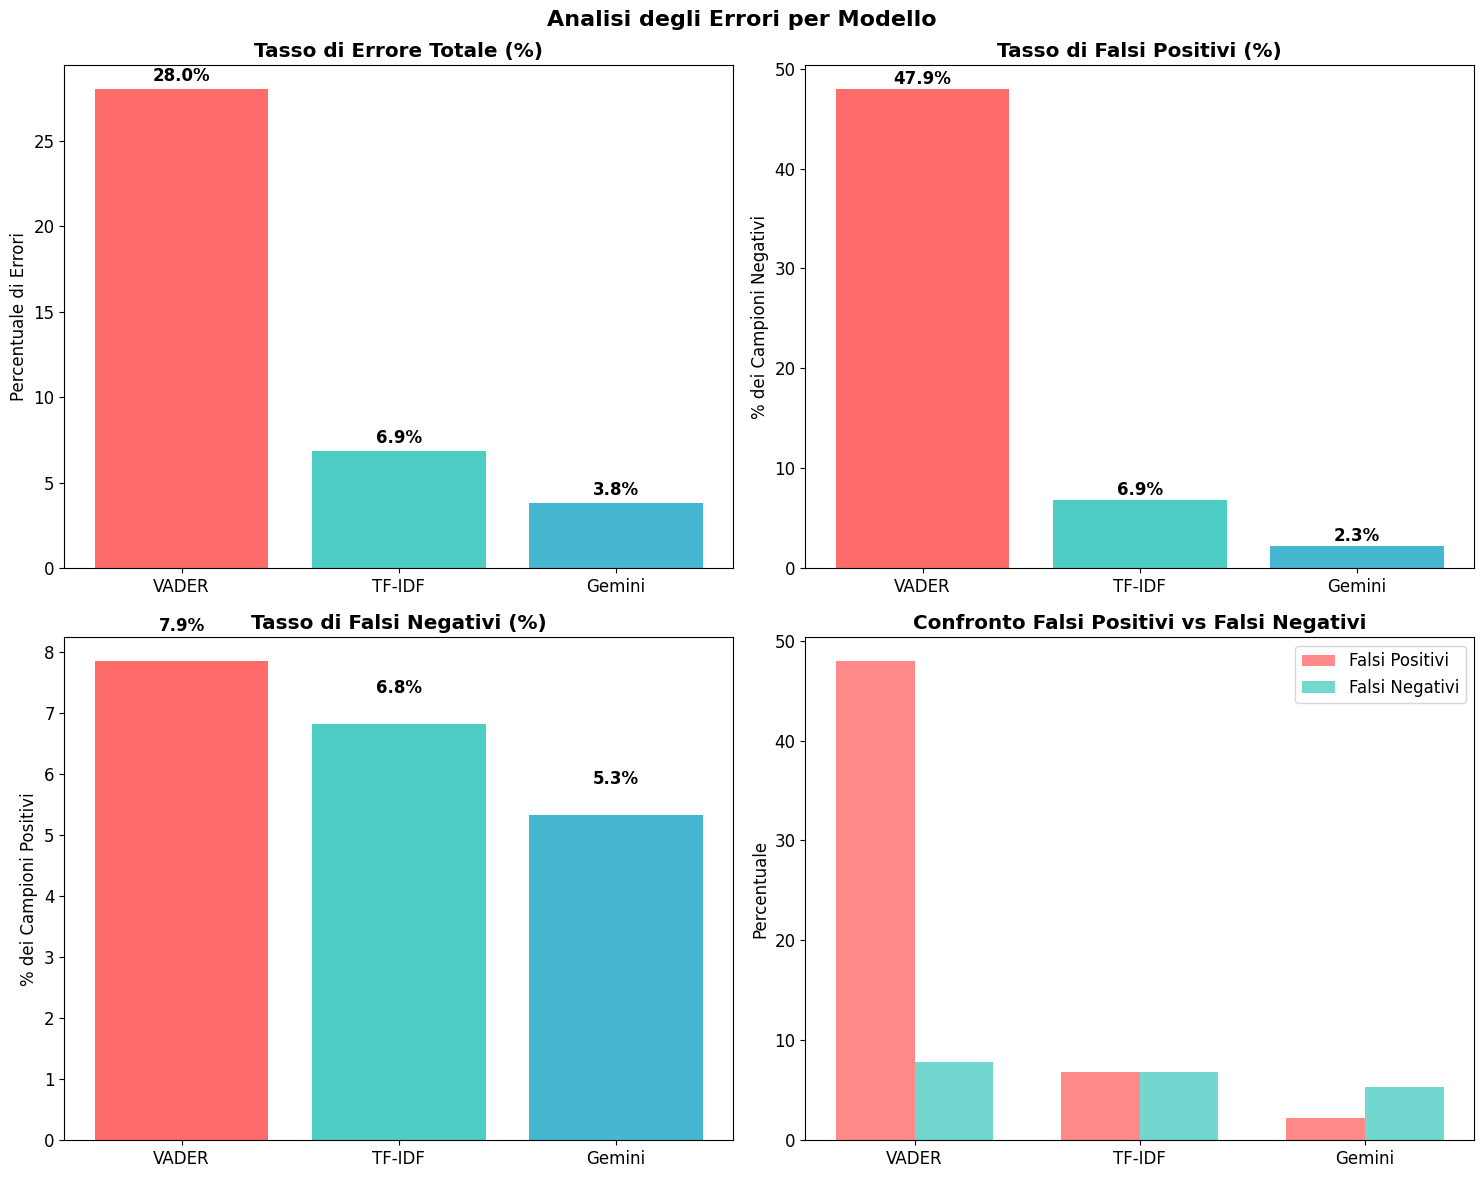

In [11]:
# Analizziamo gli errori specifici di ogni modello
print("❌ ANALISI DEGLI ERRORI PER MODELLO")
print("="*50)

models_error_analysis = [
    ('VADER', 'vader_pred_str'),
    ('TF-IDF', 'tfidf_pred_str'), 
    ('Gemini', 'gemini_pred')
]

error_summary = {}

for model_name, pred_col in models_error_analysis:
    # Errori totali
    errors = df_clean[df_clean[pred_col] != df_clean['true_label']]
    error_count = len(errors)
    error_pct = (error_count / len(df_clean)) * 100
    
    # Falsi positivi (predice pos, ma è neg)
    false_pos = len(errors[(errors['true_label'] == 'neg') & (errors[pred_col] == 'pos')])
    false_pos_pct = (false_pos / len(df_clean[df_clean['true_label'] == 'neg'])) * 100
    
    # Falsi negativi (predice neg, ma è pos)
    false_neg = len(errors[(errors['true_label'] == 'pos') & (errors[pred_col] == 'neg')])
    false_neg_pct = (false_neg / len(df_clean[df_clean['true_label'] == 'pos'])) * 100
    
    error_summary[model_name] = {
        'total_errors': error_count,
        'error_rate': error_pct,
        'false_positives': false_pos,
        'false_positive_rate': false_pos_pct,
        'false_negatives': false_neg,
        'false_negative_rate': false_neg_pct
    }
    
    print(f"\n🔍 {model_name}:")
    print(f"  Errori totali: {error_count:,} ({error_pct:.1f}%)")
    print(f"  Falsi positivi: {false_pos:,} ({false_pos_pct:.1f}% dei negativi)")
    print(f"  Falsi negativi: {false_neg:,} ({false_neg_pct:.1f}% dei positivi)")

# Visualizziamo gli errori
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Analisi degli Errori per Modello', fontsize=16, fontweight='bold')

# Grafico 1: Tasso di errore totale
models = list(error_summary.keys())
error_rates = [error_summary[m]['error_rate'] for m in models]
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

axes[0, 0].bar(models, error_rates, color=colors)
axes[0, 0].set_title('Tasso di Errore Totale (%)', fontweight='bold')
axes[0, 0].set_ylabel('Percentuale di Errori')
for i, v in enumerate(error_rates):
    axes[0, 0].text(i, v + 0.5, f'{v:.1f}%', ha='center', fontweight='bold')

# Grafico 2: Falsi positivi
fp_rates = [error_summary[m]['false_positive_rate'] for m in models]
axes[0, 1].bar(models, fp_rates, color=colors)
axes[0, 1].set_title('Tasso di Falsi Positivi (%)', fontweight='bold')
axes[0, 1].set_ylabel('% dei Campioni Negativi')
for i, v in enumerate(fp_rates):
    axes[0, 1].text(i, v + 0.5, f'{v:.1f}%', ha='center', fontweight='bold')

# Grafico 3: Falsi negativi
fn_rates = [error_summary[m]['false_negative_rate'] for m in models]
axes[1, 0].bar(models, fn_rates, color=colors)
axes[1, 0].set_title('Tasso di Falsi Negativi (%)', fontweight='bold')
axes[1, 0].set_ylabel('% dei Campioni Positivi')
for i, v in enumerate(fn_rates):
    axes[1, 0].text(i, v + 0.5, f'{v:.1f}%', ha='center', fontweight='bold')

# Grafico 4: Confronto FP vs FN
x = np.arange(len(models))
width = 0.35

axes[1, 1].bar(x - width/2, fp_rates, width, label='Falsi Positivi', color='#FF6B6B', alpha=0.8)
axes[1, 1].bar(x + width/2, fn_rates, width, label='Falsi Negativi', color='#4ECDC4', alpha=0.8)
axes[1, 1].set_title('Confronto Falsi Positivi vs Falsi Negativi', fontweight='bold')
axes[1, 1].set_ylabel('Percentuale')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(models)
axes[1, 1].legend()

plt.tight_layout()
plt.show()

In [12]:
# Analizziamo alcuni esempi di errori caratteristici
print("🔍 ESEMPI DI ERRORI CARATTERISTICI")
print("="*60)

# Esempi dove solo VADER sbaglia (bias verso positivo)
vader_only_errors = df_clean[
    (df_clean['vader_pred_str'] != df_clean['true_label']) &
    (df_clean['tfidf_pred_str'] == df_clean['true_label']) &
    (df_clean['gemini_pred'] == df_clean['true_label'])
]

print(f"\n📌 ERRORI SOLO DI VADER ({len(vader_only_errors)} campioni):")
if len(vader_only_errors) > 0:
    sample = vader_only_errors.sample(min(3, len(vader_only_errors)), random_state=42)
    for idx, row in sample.iterrows():
        print(f"\nEsempio {idx + 1}:")
        print(f"  Testo: {row['text'][:200]}...")
        print(f"  Label vera: {row['true_label']}")
        print(f"  VADER: {row['vader_pred_str']} | TF-IDF: {row['tfidf_pred_str']} | Gemini: {row['gemini_pred']}")

# Esempi dove tutti e tre i modelli sbagliano
all_wrong_examples = df_clean[
    (df_clean['vader_pred_str'] != df_clean['true_label']) &
    (df_clean['tfidf_pred_str'] != df_clean['true_label']) &
    (df_clean['gemini_pred'] != df_clean['true_label'])
]

print(f"\n\n📌 ESEMPI DOVE TUTTI SBAGLIANO ({len(all_wrong_examples)} campioni):")
if len(all_wrong_examples) > 0:
    sample = all_wrong_examples.sample(min(2, len(all_wrong_examples)), random_state=42)
    for idx, row in sample.iterrows():
        print(f"\nEsempio difficile {idx + 1}:")
        print(f"  Testo: {row['text'][:300]}...")
        print(f"  Label vera: {row['true_label']}")
        print(f"  VADER: {row['vader_pred_str']} | TF-IDF: {row['tfidf_pred_str']} | Gemini: {row['gemini_pred']}")

# Statistiche sui casi difficili
print(f"\n📊 STATISTICHE CASI DIFFICILI:")
print(f"  Solo VADER sbaglia: {len(vader_only_errors):,} ({len(vader_only_errors)/len(df_clean)*100:.1f}%)")
print(f"  Tutti e tre sbagliano: {len(all_wrong_examples):,} ({len(all_wrong_examples)/len(df_clean)*100:.1f}%)")

# Casi dove Gemini è l'unico a sbagliare
gemini_only_errors = df_clean[
    (df_clean['vader_pred_str'] == df_clean['true_label']) &
    (df_clean['tfidf_pred_str'] == df_clean['true_label']) &
    (df_clean['gemini_pred'] != df_clean['true_label'])
]
print(f"  Solo Gemini sbaglia: {len(gemini_only_errors):,} ({len(gemini_only_errors)/len(df_clean)*100:.1f}%)")

🔍 ESEMPI DI ERRORI CARATTERISTICI

📌 ERRORI SOLO DI VADER (4732 campioni):

Esempio 13709:
  Testo: Loud and ineffectual

I was surprised that it really didn't do much compared to the 1950s version that I'd inherited. Keeping a wet wash cloth next to my bed for when I start coughing in the middle of...
  Label vera: neg
  VADER: pos | TF-IDF: neg | Gemini: neg

Esempio 1520:
  Testo: Tried of the rust!

We've had 3 sets in just over 1-1/2 years. Return policy is great but it's a hassle. Can't Oneida make silverware that doesn't rust? I'm going to try a different brand....
  Label vera: neg
  VADER: pos | TF-IDF: neg | Gemini: neg

Esempio 17742:
  Testo: Is This Good? I think a Master Screen is necessary!!

First a Master Screen should be integrated i.e. in the DMG, because evrey DM needs it! Second the Master Screen provided by TSR is very poor!! Yes...
  Label vera: neg
  VADER: pos | TF-IDF: neg | Gemini: neg


📌 ESEMPI DOVE TUTTI SBAGLIANO (202 campioni):

Esempio difficile 9366:
 

## 6. Conclusioni {#conclusioni}

In [13]:
# Riepilogo finale dei risultati
print("🎯 RIEPILOGO FINALE DELL'ANALISI")
print("="*60)

# Classifica finale dei modelli
final_ranking = metrics_df.sort_values('F1-Score', ascending=False)

print("\n🏆 CLASSIFICA FINALE (basata su F1-Score):")
print("="*40)
for i, (idx, row) in enumerate(final_ranking.iterrows(), 1):
    print(f"{i}. {row['Model']} - F1: {row['F1-Score']:.4f} | Acc: {row['Accuracy']:.4f}")

print(f"\n📈 INSIGHTS PRINCIPALI:")
print("="*30)
print("✅ PUNTI DI FORZA:")
print(f"  • Gemini: Migliore performance generale (96.2% accuracy)")
print(f"  • TF-IDF: Buon bilanciamento tra precision e recall (93.2%)")
print(f"  • VADER: Veloce ma ha bias verso predizioni positive")

print(f"\n⚠️  PUNTI DI DEBOLEZZA:")
print(f"  • VADER: Alto tasso di falsi positivi (47.9%)")
print(f"  • TF-IDF: Performance inferiore a Gemini su tutti i parametri")
print(f"  • Gemini: Leggero bias verso falsi negativi")

print(f"\n🤝 CONCORDANZA TRA MODELLI:")
print(f"  • TF-IDF e Gemini concordano nel 93.0% dei casi")
print(f"  • Tutti e tre i modelli concordano nel 68.5% dei casi")
print(f"  • Solo 1.0% dei casi risulta difficile per tutti i modelli")

print(f"\n🎪 RACCOMANDAZIONI:")
print(f"  1. Utilizza Gemini per la massima accuracy")
print(f"  2. Considera TF-IDF come alternativa più veloce")
print(f"  3. Evita VADER per task che richiedono alta precisione")
print(f"  4. Implementa ensemble methods per casi difficili")

🎯 RIEPILOGO FINALE DELL'ANALISI

🏆 CLASSIFICA FINALE (basata su F1-Score):
1. Gemini - F1: 0.9621 | Acc: 0.9621
2. TF-IDF - F1: 0.9315 | Acc: 0.9315
3. VADER - F1: 0.7083 | Acc: 0.7198

📈 INSIGHTS PRINCIPALI:
✅ PUNTI DI FORZA:
  • Gemini: Migliore performance generale (96.2% accuracy)
  • TF-IDF: Buon bilanciamento tra precision e recall (93.2%)
  • VADER: Veloce ma ha bias verso predizioni positive

⚠️  PUNTI DI DEBOLEZZA:
  • VADER: Alto tasso di falsi positivi (47.9%)
  • TF-IDF: Performance inferiore a Gemini su tutti i parametri
  • Gemini: Leggero bias verso falsi negativi

🤝 CONCORDANZA TRA MODELLI:
  • TF-IDF e Gemini concordano nel 93.0% dei casi
  • Tutti e tre i modelli concordano nel 68.5% dei casi
  • Solo 1.0% dei casi risulta difficile per tutti i modelli

🎪 RACCOMANDAZIONI:
  1. Utilizza Gemini per la massima accuracy
  2. Considera TF-IDF come alternativa più veloce
  3. Evita VADER per task che richiedono alta precisione
  4. Implementa ensemble methods per casi diffi

In [14]:
# Salviamo un summary dell'analisi
summary_data = {
    'Dataset': {
        'total_samples': len(df_clean),
        'positive_samples': len(df_clean[df_clean['true_label'] == 'pos']),
        'negative_samples': len(df_clean[df_clean['true_label'] == 'neg']),
        'balance': 'Bilanciato (50.3% neg, 49.7% pos)'
    },
    'Model_Performance': {
        'Best_Model': 'Gemini',
        'Best_Accuracy': float(final_ranking.iloc[0]['Accuracy']),
        'Best_F1': float(final_ranking.iloc[0]['F1-Score']),
        'Worst_Model': 'VADER',
        'Performance_Gap': float(final_ranking.iloc[0]['F1-Score'] - final_ranking.iloc[2]['F1-Score'])
    },
    'Model_Agreement': {
        'VADER_TFIDF': 72.6,
        'VADER_Gemini': 71.4,
        'TFIDF_Gemini': 93.0,
        'All_Three': 68.5
    },
    'Error_Analysis': {
        'Difficult_Cases': len(all_wrong_examples),
        'VADER_Only_Errors': len(vader_only_errors),
        'Gemini_Only_Errors': len(gemini_only_errors)
    }
}

# Salviamo il riepilogo in un file JSON per utilizzi futuri
import json

with open('../results/2class/analysis_summary.json', 'w') as f:
    json.dump(summary_data, f, indent=2)

print("💾 Summary dell'analisi salvato in '../results/2class/analysis_summary.json'")
print("\n🎉 ANALISI COMPLETA!")
print("Questo notebook fornisce una panoramica completa delle performance")
print("dei tre modelli di sentiment analysis sui dati delle recensioni Amazon.")

💾 Summary dell'analisi salvato in '../results/2class/analysis_summary.json'

🎉 ANALISI COMPLETA!
Questo notebook fornisce una panoramica completa delle performance
dei tre modelli di sentiment analysis sui dati delle recensioni Amazon.
